# Solution of Group 6
by Alex & Paul (yes only two, we got ditched)

The optimization steps in this code only use small numbers of iterations due to long compute times.
The plots for many iterations can be found in the google drive.

In [ ]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install jupyter
!pip install qiskit[visualization]==1.2
# For Local Linux or Mac, you can use the following command:
# # !pip install 'qiskit[visualization]'==1.2
!pip install qiskit_algorithms
!pip install qiskit_aer >= 0.14
!pip install qiskit_ibm_runtime
!pip install qiskit_ibm_transpiler
!pip install qiskit_aer
!pip install qiskit_algorithms

import scipy as sci

# 1.1 Ground State Energy of XXZ

In [2]:
import numpy as np

from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


def nqubit_ferromagnetic_gs(nqubits: int) -> np.ndarray:
    """Returns the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        state (np.ndarray): The ground state of the system.
    """
    up = np.zeros((nqubits, 2))
    up[:, 0] = 1
    down = np.zeros((nqubits, 2))
    down[:, 1] = 1
    x = np.random.rand()
    if x > 0.5:
        state = up
    else:
        state = down
    return state


def nqubit_ferromagnetic_gs_circuit(state_vector: np.ndarray) -> QuantumCircuit:
    """Returns the energy of the ground state of a n-qubit ferromagnetic Ising model.

    Args:
        state_vector (np.ndarray): The state vector of the system.

    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    nqubits = state_vector.shape[0]
    circuit = QuantumCircuit(nqubits)

    for i in range(nqubits):
        circuit.initialize(state_vector[i, :], i)

    return circuit


def nqubit_XXZ_hamiltonian(nqubits: int, delta: float) -> SparsePauliOp:
    """Returns the Hamiltonian of a n-qubit ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
    """
    # define the single Pauli terms as ("Paulis", [indices], coefficient)
    X = [("XX", [i, i + 1], -1 / 4) for i in range(nqubits - 1)]  # we assume spins on a 1D line
    X.append(("XX", [nqubits - 1, 0], -1 / 4))  # to close loop
    Y = [("YY", [i, i + 1], -1 * 0.25) for i in range(nqubits - 1)]
    Y.append(("YY", [nqubits - 1, 0], -1 / 4))
    Z = [("ZZ", [i, i + 1], -delta / 4) for i in range(nqubits - 1)]
    Z.append(("ZZ", [nqubits - 1, 0], -delta / 4))

    # build the operator
    hamiltonian = SparsePauliOp.from_sparse_list((X + Y + Z), num_qubits=nqubits)

    return hamiltonian


def compute_expected_value(circuit: QuantumCircuit, hamiltonian: SparsePauliOp) -> float:
    """Returns the expected value of the prepared state of the given circuit, and the passed operator.

    Args:
        circuit (qiskit.circuit.QuantumCircuit): The circuit that prepares the state.
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.

    Returns:
        energy_gs (float): The energy of the circuit state.
    """
    # Expectation value <psi_gs|H|psi_gs>
    # Simulate the state using Statevector without the need for a backend
    statevector = Statevector.from_instruction(circuit)

    # Calculate the expected value of the Hamiltonian in the simulated ground state
    energy_gs = statevector.expectation_value(hamiltonian)
    return energy_gs

In [3]:
# Parameters
nqubits = 12
delta = 4

# Computations
fm_gs_vector = nqubit_ferromagnetic_gs(nqubits)
fm_gs_circuit = nqubit_ferromagnetic_gs_circuit(fm_gs_vector)
fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
fm_gs_energy = compute_expected_value(fm_gs_circuit, fm_hamiltonian)

print(f"Expected energy: {-nqubits}, obtained energy: {fm_gs_energy}")

Expected energy: -12, obtained energy: (-12+0j)


### ANTIFERROMAGNETIC EXACT SOLUTION

In [4]:
def obtain_first_hamiltonian_eigenvalue(hamiltonian: SparsePauliOp) -> tuple[np.ndarray, float]:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model.
        This function uses the exact diagonalization method to compute the ground state.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian to diagonalize.

    Returns:
        state (np.ndarray): The ground state of the system.
        energy_gs (float): The energy of the ground state.
    """
    # Takes long with many qubits
    hamiltonian = sci.sparse.csr_array(hamiltonian)
    # eigen_vals, eigen_vecs = sci.sparse.linalg.eigsh(hamiltonian, k=1)
    eigenvalues, eigenvectors = sci.sparse.linalg.eigsh(hamiltonian)
    energy_gs = eigenvalues[0]
    return energy_gs

In [5]:
# Takes Long, large matrix (4096 x 4096) to diagonalize
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_numerical_energy = obtain_first_hamiltonian_eigenvalue(anti_fm_hamiltonian)

print(f"Obtained energy: {anti_fm_numerical_energy}")

Obtained energy: -7.460117375510894


In [6]:
import numpy as np
from qiskit import QuantumCircuit

import numpy as np


def nqubit_antiferromagnetic_gs(nqubits: int) -> np.ndarray:
    """Returns the normalized linear combination of the two possible ground states of a n-qubit
    antiferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        state (np.ndarray): The normalized linear combination of the two antiferromagnetic ground states.
    """
    # First antiferromagnetic state (0, 1, 0, 1, ...)
    state1 = np.zeros((nqubits, 2))
    state1[::2, 0] = 1  # Qubits in even positions are "up" (|0⟩)
    state1[1::2, 1] = 1  # Qubits in odd positions are "down" (|1⟩)

    # Second antiferromagnetic state (1, 0, 1, 0, ...)
    state2 = np.zeros((nqubits, 2))
    state2[::2, 1] = 1  # Qubits in even positions are "down" (|1⟩)
    state2[1::2, 0] = 1  # Qubits in odd positions are "up" (|0⟩)

    x = np.random.rand()
    if x > 0.5:
        state = state1
    else:
        state = state2
    return state


def nqubit_antiferromagnetic_gs_circuit(state_vector: np.ndarray) -> QuantumCircuit:
    """Returns the circuit that prepares the state for the antiferromagnetic Ising model.

    Args:
        state_vector (np.ndarray): The state vector of the system.

    Returns:
        circuit (qiskit.QuantumCircuit): The circuit that prepares the state.
    """
    nqubits = state_vector.shape[0]
    circuit = QuantumCircuit(nqubits)

    for i in range(nqubits):
        circuit.initialize(state_vector[i, :], i)

    return circuit


In [7]:
nqubits = 12
delta = -2

anti_fm_hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
anti_fm_gs_state = nqubit_antiferromagnetic_gs(nqubits)
anti_fm_initial_guess_circuit = nqubit_antiferromagnetic_gs_circuit(anti_fm_gs_state)

anti_fm_initial_guess_energy = compute_expected_value(anti_fm_initial_guess_circuit, anti_fm_hamiltonian)

print(f"Minimum, numerical energy: {anti_fm_numerical_energy}, Obtained energy: {anti_fm_initial_guess_energy}")
print(f"Error: {np.abs(anti_fm_numerical_energy - anti_fm_initial_guess_energy)}")

Minimum, numerical energy: -7.460117375510894, Obtained energy: (-6+0j)
Error: 1.4601173755108938


## VQE $\Delta$ = -2

Use the VQE algorithm to estimate the GS energy for Δ=-2

In [10]:
import numpy as np
from qiskit_algorithms.optimizers import *
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp, Statevector

In [11]:
def create_ansatz_vqe(n_qubits: int, ansatz_type: str, nlayers: int) -> QuantumCircuit:
    """Returns the ansatz for the VQE algorithm.

    Args:
        n_qubits (int): The number of qubits in the system.
        ansatz_type (str): The type of two qubit gates used in the ansatz.
        nlayers (int): The number of layers in the ansatz.

        --You can use extra Args if you need it

    Returns:
        ansatz (qiskit.QuantumCircuit): The ansatz for the VQE algorithm.
    """
    # Create SU2 ansatz ci
    ansatz = EfficientSU2(n_qubits, reps=nlayers, entanglement=ansatz_type)

    return ansatz

Number of parameters: 144


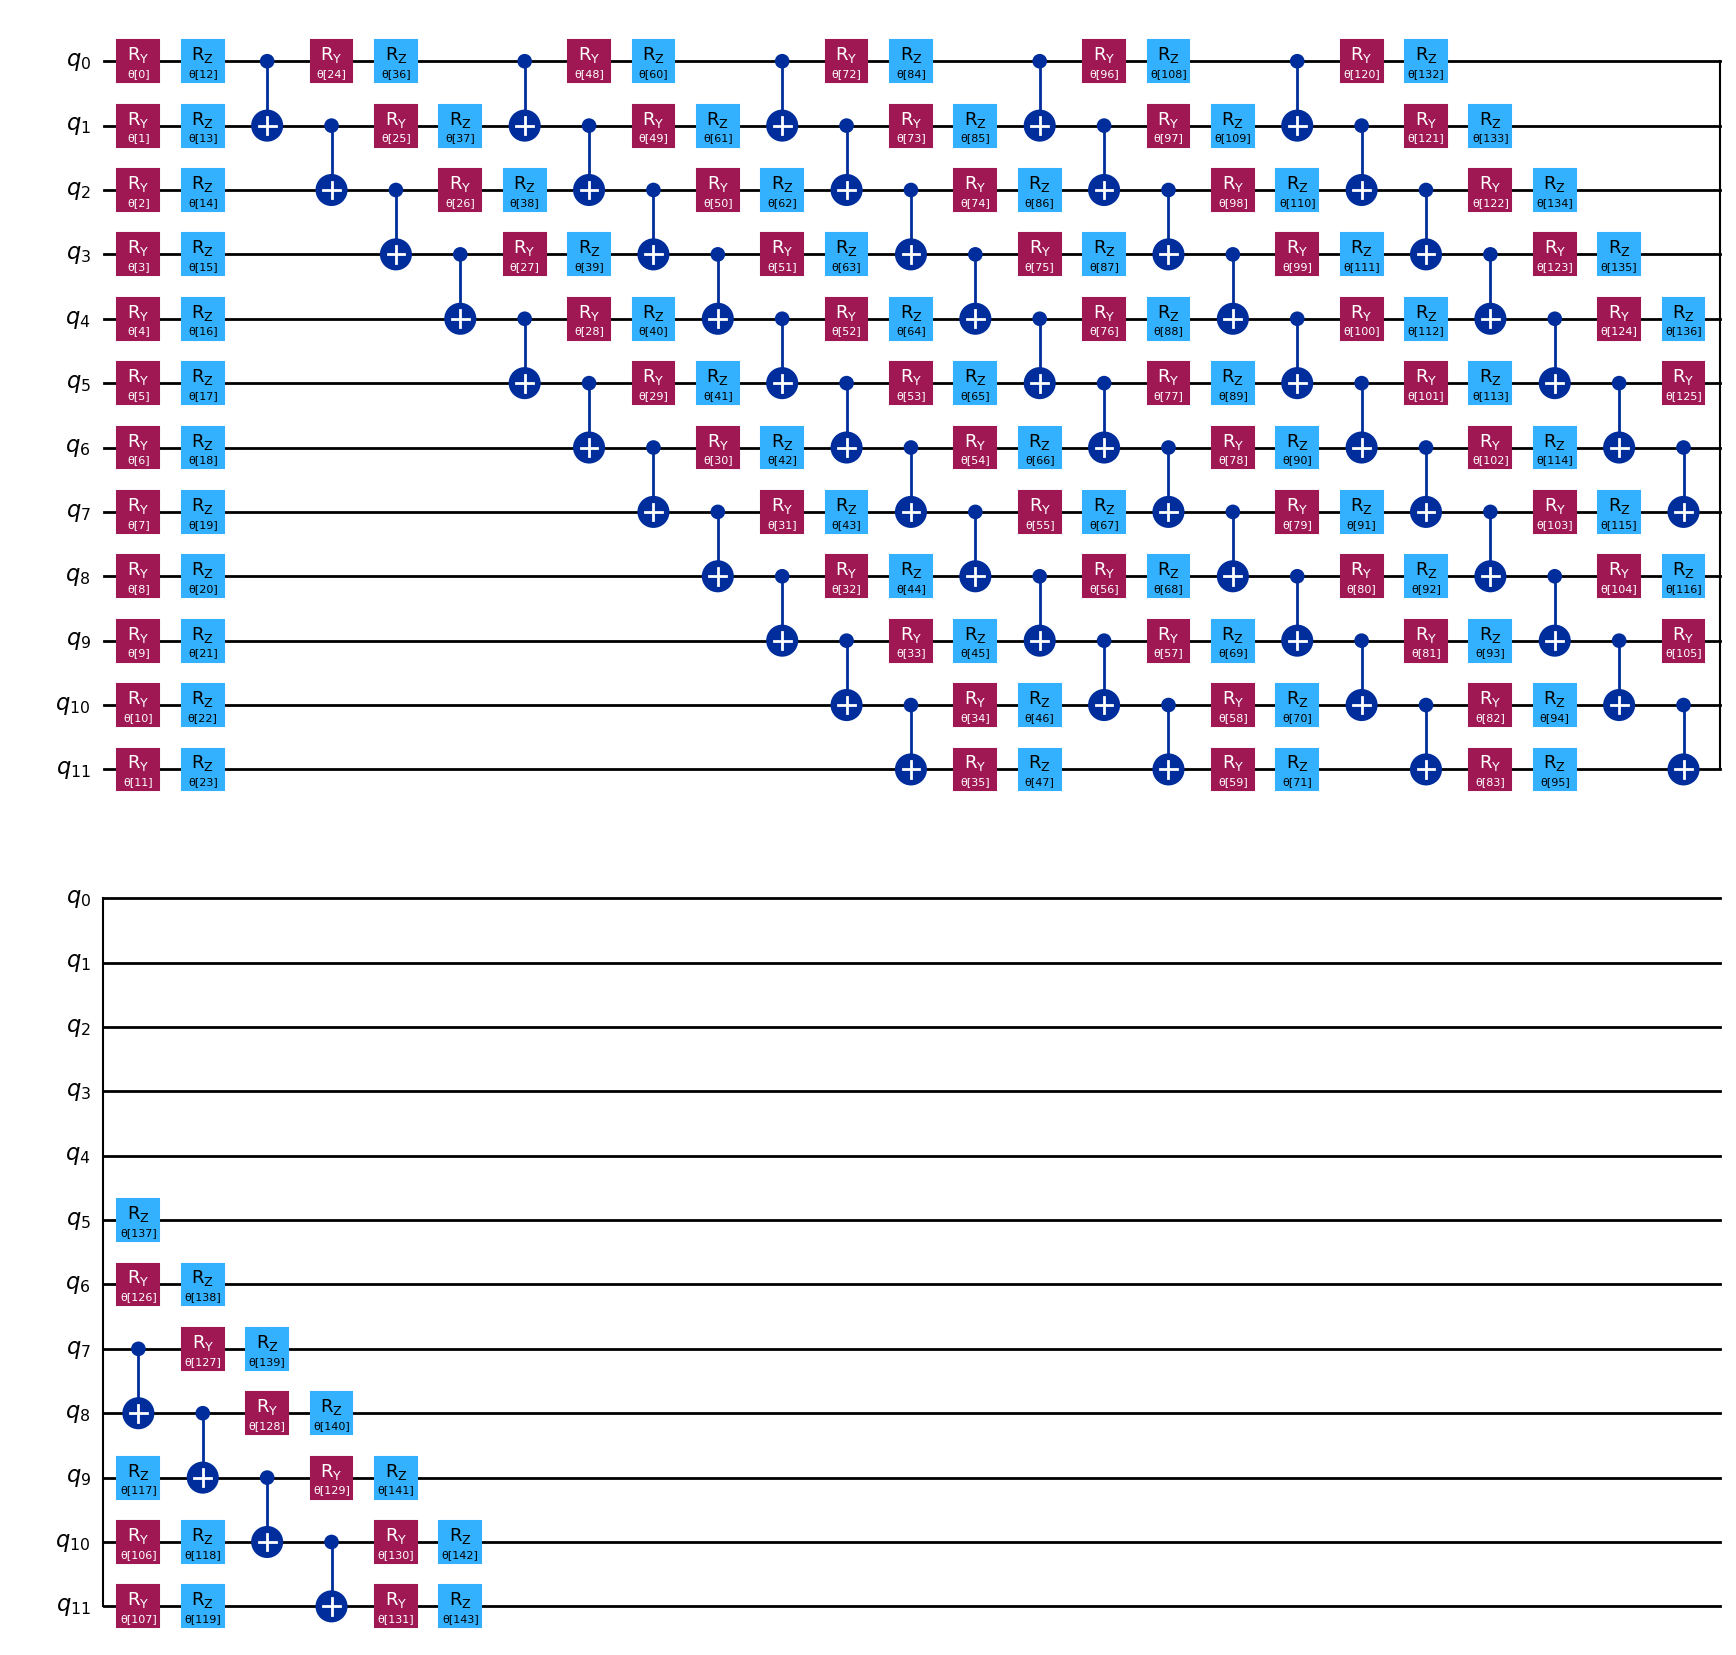

In [12]:
ansatz_circuit = create_ansatz_vqe(12, "linear", 5)

param_array = list(ansatz_circuit.parameters)

num_params = ansatz_circuit.num_parameters
print(f"Number of parameters: {num_params}")  # print the number of parameters of the qc


ansatz_circuit.decompose().draw(output="mpl", style="iqp")  # Draw the circuit

In [13]:
# Función VQE para encontrar la energía del estado base
def nqubit_anti_fm_gs_energy_vqe(
    hamiltonian: SparsePauliOp,
    ansatz: QuantumCircuit,
    initial_params: np.ndarray,
    optimizer,
    backend=AerSimulator(),
    printing=False,
) -> float:
    """Returns the ground state of a n-qubit antiferromagnetic XXZ Heisenberg model."""

    backend = AerSimulator()
    ansatz = transpile(ansatz, AerSimulator())

    # Crear el estimador con el backend local
    estimator = Estimator(backend)
    cost_history_dict = {"prev_vector": None, "iters": 0, "cost_history": []}

    # Definir la función de costo (energía)
    def cost_func(params):
        job = estimator.run([(ansatz, hamiltonian, [params])])
        energy = job.result()[0].data.evs[0]

        cost_history_dict["iters"] += 1
        cost_history_dict["prev_vector"] = params
        cost_history_dict["cost_history"].append(energy)

        if printing:
            if cost_history_dict["iters"] % 10 == 1:
                print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

        return energy

    # Minimizar la energía utilizando el optimizador (ej. COBYLA)
    result = optimizer.minimize(cost_func, initial_params)

    # Retornar la energía mínima encontrada
    gs_energy = result.fun

    # Extract the optimized parameters
    optimized_parameters = result.x

    # Create the quantum circuit for the optimized state
    ansatz = ansatz.assign_parameters(optimized_parameters)

    # job = estimator.run([(ansatz, hamiltonian, [optimized_parameters])])
    # optimized_state = job.result() # this has to be fixed

    optimized_state = Statevector(ansatz)

    return gs_energy, cost_history_dict, optimized_state

In [14]:
# Crear un ejemplo del Hamiltoniano
nqubits = 12
delta = -2
hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)

# Crear el ansatz
ansatz_circuit = create_ansatz_vqe(nqubits, "linear", 3)

# Parámetros iniciales aleatorios
# initial_params = 2 * np.pi * np.random.random(ansatz_circuit.num_parameters) # param_array
initial_params = initial_params = np.full(ansatz_circuit.num_parameters, 0.1)  # Un valor inicial pequeño constante


# Optimizer (COBYLA, por ejemplo)
optimizer = SPSA(maxiter=5)

# Ejecutar el VQE para obtener la energía del estado base
gs_energy, cost_history, gs_state = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian, ansatz_circuit, initial_params, optimizer, printing=True
)

# Imprimir la energía del estado base
print(f"Ground state energy: {gs_energy}")


Iters. done: 1 [Current cost: 4.140625]
Iters. done: 11 [Current cost: 3.70947265625]
Iters. done: 21 [Current cost: 4.139892578125]
Iters. done: 31 [Current cost: 3.86572265625]
Iters. done: 41 [Current cost: 4.035400390625]
Iters. done: 51 [Current cost: 3.670654296875]
Iters. done: 61 [Current cost: -0.077880859375]
Ground state energy: -0.077880859375


# 1.2 Ansatz Expressability

- **Ansatz**:

   - Choose the type of entanglement between ‘linear’, ‘pairwise’,‘circular’.

   
 - **Optimizers**:

   - Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SPSA.html#qiskit_algorithms.optimizers.SPSA)) ;
   - Constrained Optimization By Linear Approximation ([COBYLA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.COBYLA.html#qiskit_algorithms.optimizers.COBYLA));
   - Sequential Least SQuares Programming ([SLSQP](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.SLSQP.html#qiskit_algorithms.optimizers.SLSQP)).

   SLSQP was not working for us.
   Results with many iterations are in the drive.



In [16]:
# this is crazy slow
# SLSQP not working or way to slow
import time

entanglement_ls = ["linear", "pairwise", "circular"]
optimizer_ls = ["SPSA", "COBYLA"]  # 'SLSQP' mssing, crazy slow

# Create Hamiltonian
nqubits = 12
delta = -2
hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)

result = {}
for entanglement in entanglement_ls:
    for opt in optimizer_ls:
        # Crear el ansatz
        ansatz_circuit = create_ansatz_vqe(nqubits, entanglement, 3)

        initial_params = 2 * np.pi * np.random.random(ansatz_circuit.num_parameters)

        if opt == "SPSA":
            optimizer = SPSA(maxiter=100)
        if opt == "COBYLA":
            optimizer = COBYLA(maxiter=100)
        if opt == "SLSQP":
            optimizer = SLSQP(maxiter=100)
        name = entanglement + " / " + opt
        print("Doing " + name)
        # Ejecutar el VQE para obtener la energía del estado base
        start = time.time()
        idv_result = nqubit_anti_fm_gs_energy_vqe(hamiltonian, ansatz_circuit, initial_params, optimizer)
        duration = time.time() - start
        print(duration)
        print(idv_result[0])
        result[name] = [*idv_result, duration]


Doing linear / SPSA
55.81122446060181
-2.326904296875
Doing linear / COBYLA
22.48597288131714
-2.0888671875
Doing pairwise / SPSA
52.170692682266235
-2.45068359375
Doing pairwise / COBYLA
19.684925079345703
-1.395263671875
Doing circular / SPSA
73.95764636993408
-1.840576171875
Doing circular / COBYLA
31.49926733970642
-1.225341796875


Text(0, 0.5, 'Optimization Time [s]')

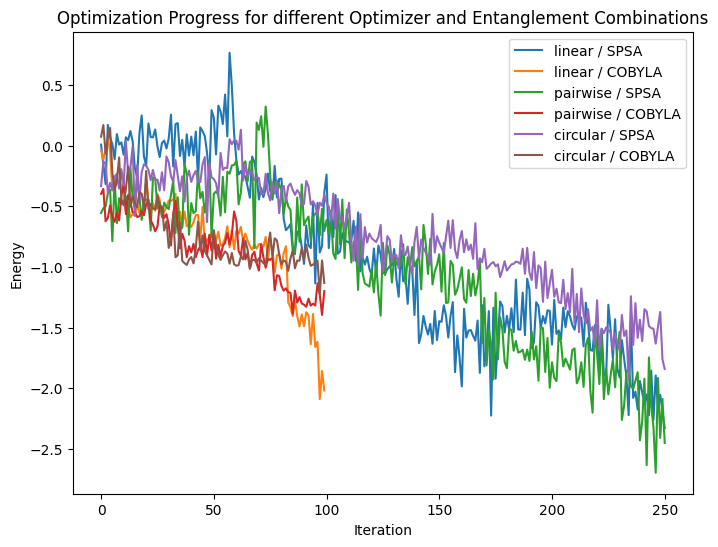

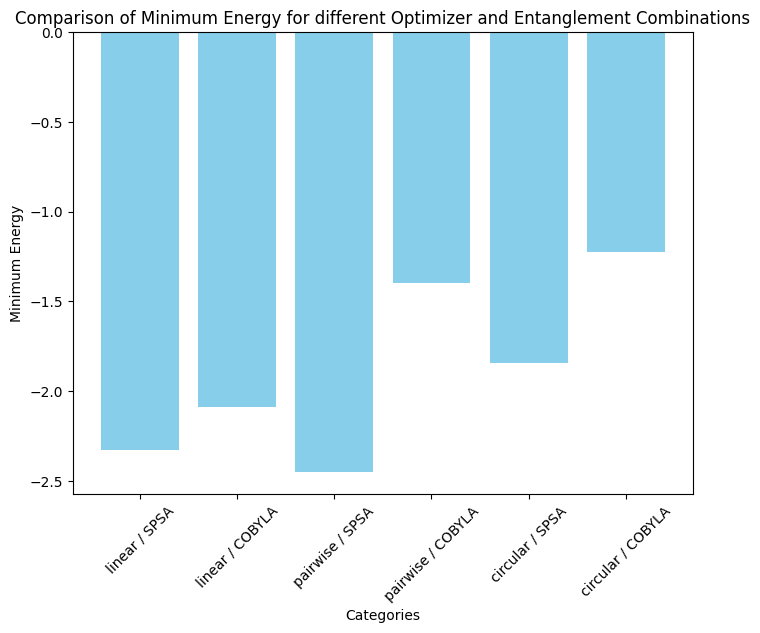

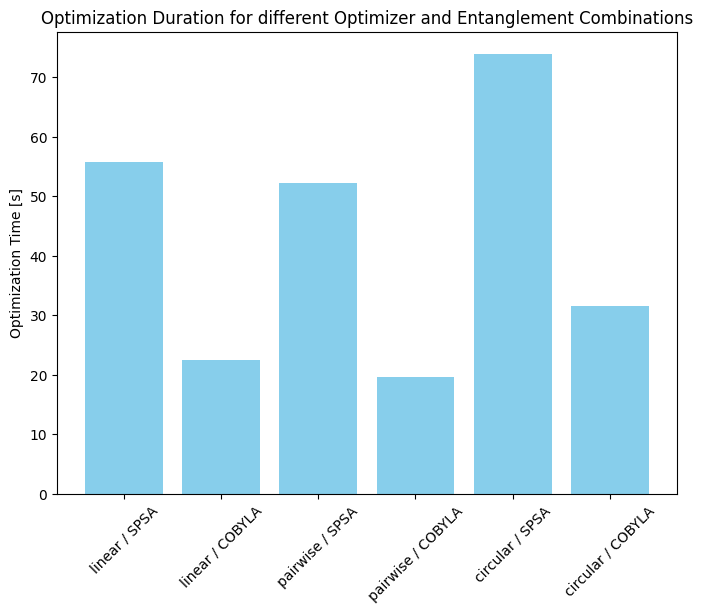

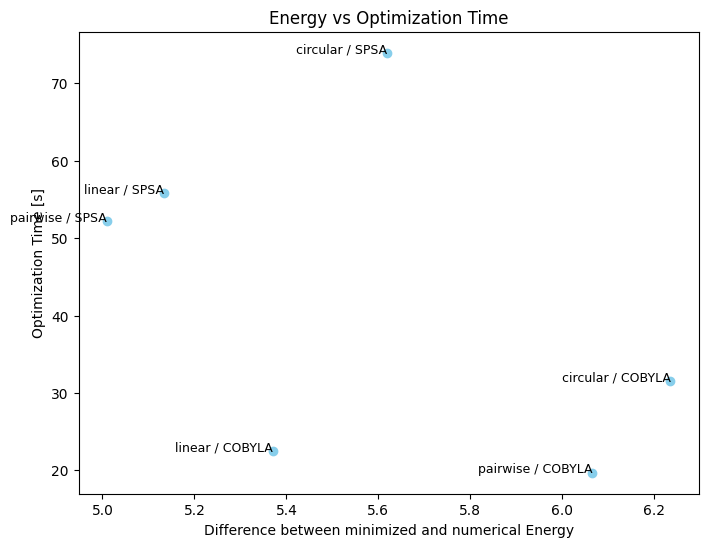

In [18]:
# Plot previous Calculations
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Optimization Progress for different Optimizer and Entanglement Combinations")
for i in result:
    plt.plot(result[i][1]["cost_history"], label=i)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
# plt.xlim([0, 350])

plt.figure(figsize=(8, 6))
plt.title("Comparison of Minimum Energy for different Optimizer and Entanglement Combinations")
keys = list(result.keys())
values = [value[0] for value in result.values()]
plt.bar(keys, values, color="skyblue")
plt.xlabel("Categories")
plt.ylabel("Minimum Energy")
plt.xticks(rotation=45)

plt.figure(figsize=(8, 6))
plt.title("Optimization Duration for different Optimizer and Entanglement Combinations")
keys = list(result.keys())
values = [value[-1] for value in result.values()]
plt.bar(keys, values, color="skyblue")
plt.ylabel("Optimization Time [s]")
plt.xticks(rotation=45)

plt.figure(figsize=(8, 6))
plt.title("Energy vs Optimization Time")
keys = list(result.keys())
x_values = [abs(value[0] - anti_fm_numerical_energy) for value in result.values()]
y_values = [value[-1] for value in result.values()]
plt.scatter(x_values, y_values, color="skyblue")
for i, key in enumerate(keys):
    plt.text(x_values[i], y_values[i], key, fontsize=9, ha="right")
plt.xlabel("Difference between minimized and numerical Energy")
plt.ylabel("Optimization Time [s]")


# 1.3 Phase Diagrams
This is a low iteration example. A version with 3000 iterations is stored in the google drive, this includes the plots as  well as the list_gs_viles variable stored as a pickle file.

### Functions

In [19]:
from qiskit.quantum_info import Pauli


def compute_magnetization(state_vector) -> float:
    """Returns the magnetization of the system, given a state,

    Args:
        state_vector (np.ndarray): Desired state, to compute the magnetization from.

    Returns:
        magnetization (float): The average magnetization of the system, in the given state.
    """

    nqubits = state_vector.num_qubits
    magnetization_operator = SparsePauliOp.from_list(
        [("I" * i + "Z" + "I" * (nqubits - i - 1), 1.0) for i in range(nqubits)]
    )
    magnetization = (
        np.real(state_vector.expectation_value(magnetization_operator)) / nqubits
    )  # dividing by 2 for 1/2 or -1/2?
    return magnetization


def compute_staggered_magnetization(state_vector: np.ndarray) -> float:
    """Returns the staggered magnetization of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the staggered magnetization from.

    Returns:
        staggered_magnetization (float): The average magnetization of the system, in the given state.
    """
    nqubits = state_vector.num_qubits
    magnetization_operator = SparsePauliOp.from_list(
        [("I" * i + "Z" + "I" * (nqubits - i - 1), (-1) ** i) for i in range(nqubits)]
    )
    magnetization = np.real(state_vector.expectation_value(magnetization_operator)) / nqubits
    return magnetization


def compute_nearest_neighbour_correlator(state_vector: np.ndarray) -> float:
    """Returns the nearest neighbour correlator of the system, given a state.

    Args:
        state_vector (np.ndarray): Desired state, to compute the nearest neighbour correlator from.

    Returns:
        nearest_neighbour_correlator (float): The average nearest neighbour correlator of the system.
    """
    nqubits = state_vector.num_qubits
    # Construimos el operador ZZ para los vecinos más cercanos
    operator_list = []
    for i in range(nqubits - 1):
        pauli_str = "I" * i + "ZZ" + "I" * (nqubits - i - 2)
        operator_list.append((pauli_str, 1.0))

    # Incluimos el último par de vecinos con la condición de frontera periódica
    pauli_str = "Z" + "I" * (nqubits - 2) + "Z"
    operator_list.append((pauli_str, 1.0))

    # Convertimos la lista de operadores Pauli a SparsePauliOp
    correlator_operator = SparsePauliOp.from_list(operator_list)

    # Calculamos el valor esperado (correlador de vecinos más cercanos)
    nearest_neighbour_correlator = np.real(state_vector.expectation_value(correlator_operator)) / nqubits / 4
    return nearest_neighbour_correlator

### Function to obtain Circuit Params

In [20]:
def compute_gs_state_vqe(nqubits, hamiltonian, ansatz, initial_params, optimizer) -> np.ndarray:
    """Returns the VQE optimal state vector of the circuit, to generate the ground state of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        gs_state (np.ndarray): The optimized state vector representing the ground state.
    """
    gs_energy, cost_history, gs_state = nqubit_anti_fm_gs_energy_vqe(hamiltonian, ansatz, initial_params, optimizer)
    return gs_state, gs_energy


### Calculate

In [21]:
nqubits = 12

optimal_ansatz = create_ansatz_vqe(nqubits, "linear", 3)
optimal_optimizer = SPSA(maxiter=50)
# optimal_initial_params = 2 * np.pi * np.random.random(optimal_ansatz.num_parameters) # param_array
optimal_initial_params = initial_params = np.full(ansatz_circuit.num_parameters, 0.1)

perturbation = 0

deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]

hamiltonians: list[SparsePauliOp] = [nqubit_XXZ_hamiltonian(nqubits, delta=delta) for delta in deltas]

list_gs_states = []

for delta, hamiltonian in zip(deltas, hamiltonians):  # Recorre los deltas y hamiltonianos simultáneamente
    vqe_optimal_parameters, ge = compute_gs_state_vqe(
        nqubits, hamiltonian, optimal_ansatz, optimal_initial_params, optimal_optimizer
    )
    list_gs_states.append(vqe_optimal_parameters)
    print(f"Hamiltonian: delta={delta} gs_state={vqe_optimal_parameters} E={ge}")

Hamiltonian: delta=-2 gs_state=Statevector([-0.00491764+0.00598992j,  0.00315191-0.00685684j,
              0.00212571+0.00193933j, ..., -0.00168658+0.00631201j,
             -0.01115992-0.00772806j,  0.00183809-0.00012417j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)) E=-1.575439453125
Hamiltonian: delta=-1.5 gs_state=Statevector([ 0.00671485-0.00231181j, -0.00416755+0.00298322j,
             -0.01169186-0.01334564j, ...,  0.00090638+0.00049675j,
              0.00077116+0.0014993j , -0.00162241+0.0026591j ],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)) E=-1.139404296875
Hamiltonian: delta=-1 gs_state=Statevector([ 0.0010234 -0.0004202j ,  0.00273616-0.00438687j,
              0.00401243+0.00053136j, ..., -0.01746963+0.02006716j,
             -0.00146865-0.00495791j,  0.00589812-0.00149989j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)) E=-1.22802734375
Hamiltonian: delta=-0.5 gs_state=Statevector([-0.00929532+0.01362589j,  0.01914986-0.00048881j,
      

### Calculate Magnetizations

In [22]:
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []


for ground_state_vector in list_gs_states:
    magnetizations.append(compute_magnetization(ground_state_vector))
    staggered_magnetizations.append(compute_staggered_magnetization(ground_state_vector))
    nearest_neighbour_correlators.append(compute_nearest_neighbour_correlator(ground_state_vector))

### Plot Phase Diagram

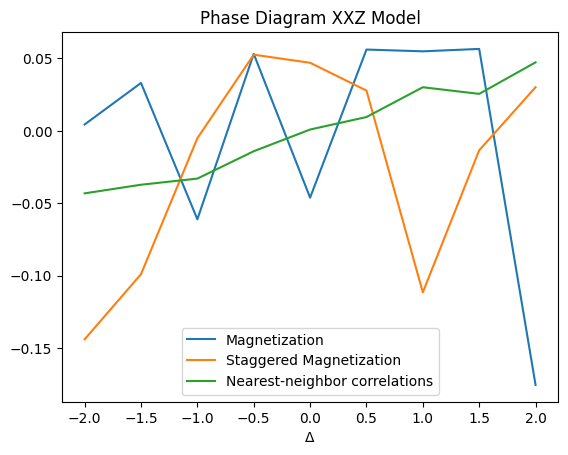

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Phase Diagram XXZ Model")

plt.plot(deltas, magnetizations, label="Magnetization")
plt.plot(deltas, staggered_magnetizations, label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlators, label="Nearest-neighbor correlations")
plt.xlabel("$\Delta$")
plt.legend()
plt.show()


# 1.4 Excited State

## Define Functions

In [24]:
from qiskit_algorithms import VQD
from qiskit.primitives import Sampler, Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_algorithms.state_fidelities import ComputeUncompute

counts = []
values = []
steps = []


def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)


def compute_first_excited_energy_vqd(hamiltonian, ansatz, initial_params, optimizer, nqubits, small_delta=0.1) -> float:
    """Returns the VQD first excited state energy, of the system.

    Args:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
        ansatz (qiskit.QuantumCircuit): The circuit ansatz to use.
        initial_params (np.ndarray): The initial parameters for the ansatz.
        optimizer (qiskit_algorithms.optimizers.Optimizer): The optimizer to use.

    Returns:
        first_excited_energy (float): The first excited state energy.
    """
    hamiltonian = hamiltonian + SparsePauliOp.from_sparse_list(([("Z", [0], small_delta)]), num_qubits=nqubits)
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    estimator = Estimator()

    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=2, callback=callback)
    result = vqd.compute_eigenvalues(operator=hamiltonian)
    vqd_values = result.eigenvalues.real
    return vqd_values[1] - vqd_values[0]


def compute_gap(nqubits, delta):
    """Returns the gap between the ground state and the excited state."""
    hamiltonian = nqubit_XXZ_hamiltonian(nqubits, delta)
    ansatz = create_ansatz_vqe(nqubits, "linear", 3)
    optimizer = SPSA(maxiter=500)
    excited_state = compute_first_excited_energy_vqd(hamiltonian, ansatz, initial_params, optimizer, nqubits)
    # gs = obtain_first_hamiltonian_eigenvalue(hamiltonian)
    return excited_state  #  - gs

## Calculate

In [25]:
# Mind long compute time
nqubits = 12
deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
gaps = []

for delta in deltas:
    print("Doing Delta=" + str(delta))
    gap = compute_gap(nqubits, delta)
    gaps.append(gap)
    print("Gap is: " + str(gap))

Doing Delta=-2


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: -0.013572567524400725
Doing Delta=-1.5


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: 1.7098434387085852
Doing Delta=-1


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: -0.3087607765027238
Doing Delta=-0.5


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: 0.48798894004215665
Doing Delta=0


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: -0.024024670928513903
Doing Delta=0.5


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: 0.4015621274919092
Doing Delta=1


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: -0.11776100594503047
Doing Delta=1.5


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: -0.896657469917701
Doing Delta=2


<ipython-input-24-ec971a28ad92>:29: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
<ipython-input-24-ec971a28ad92>:31: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Gap is: -0.2937291218181848


## Plot

Text(0, 0.5, 'Energy Gap')

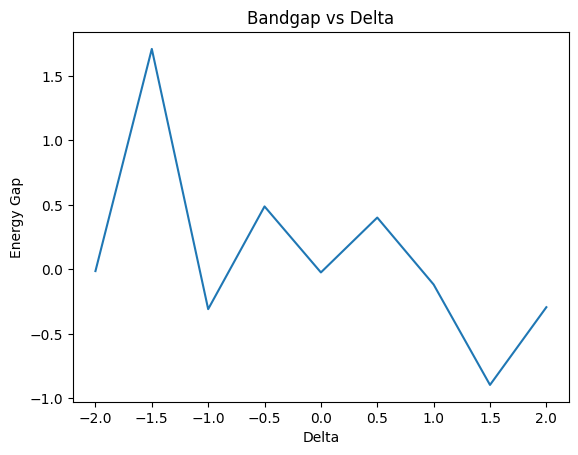

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Bandgap vs Delta")
plt.plot(deltas, gaps)
plt.xlabel("Delta")
plt.ylabel("Energy Gap")

# 2 The Ring Empire strikes back

In [27]:
nearest_neighbour_dict = {
    0: [2, 3],
    1: [2, 5],
    2: [0, 1, 3, 5],
    3: [0, 2, 4, 6],
    4: [3, 6],
    5: [1, 2, 7, 8],
    6: [3, 4, 9, 10],
    7: [5, 8],
    8: [5, 7, 9, 11],
    9: [6, 8, 10, 11],
    10: [6, 9],
    11: [8, 9],
}

In [28]:
def ring_XXZ_hamiltonian(nearest_neighbour_dict: dict, delta: float) -> SparsePauliOp:
    """Returns the Hamiltonian of a ring empire ferromagnetic Ising model.

    Args:
        nqubits (int): The number of qubits in the system.

    Returns:
        hamiltonian (qiskit.quantum_info.SparsePauliOp): The Hamiltonian of the system.
    """
    X = []
    Y = []
    Z = []
    for key in nearest_neighbour_dict:
        n_neighbours = len(nearest_neighbour_dict[key])
        if n_neighbours > 1:
            neighbors = nearest_neighbour_dict[key]
            X_buff = [("XX", [key, neighbors[i]], -1 / 4) for i in range(n_neighbours)]
            X.extend(X_buff)

            Y_buff = [("YY", [key, neighbors[i]], -1 / 4) for i in range(n_neighbours)]
            Y.extend(Y_buff)

            Z_buff = [("ZZ", [key, neighbors[i]], -1 / 4 * delta) for i in range(n_neighbours)]
            Z.extend(Z_buff)

    # build the operator
    hamiltonian = SparsePauliOp.from_sparse_list((X + Y + Z), num_qubits=len(nearest_neighbour_dict.keys()))

    return hamiltonian


## 2.1 Repeat and Refine

### Numerical gs Energy

In [29]:
import scipy as sci

delta = 1
ring_hamiltonian = sci.sparse.csr_array(ring_XXZ_hamiltonian(nearest_neighbour_dict, delta))
eigen_vals, eigen_vecs = sci.sparse.linalg.eigsh(ring_hamiltonian, k=1)
print("Groundstate Energy of Kagome lattice: " + str(eigen_vals[0]))

Groundstate Energy of Kagome lattice: 9.000000000000057


### VQE Energy

In [33]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

delta = 1

hamiltonian = ring_XXZ_hamiltonian(nearest_neighbour_dict, delta)
nqubits = len(nearest_neighbour_dict.keys())

ansatz_circuit = create_ansatz_vqe(nqubits, "circular", 3)
initial_params = 2 * np.pi * np.random.random(ansatz_circuit.num_parameters)  # param_array

optimizer = SPSA(maxiter=500)

gs_energy, cost_history, gs_state = nqubit_anti_fm_gs_energy_vqe(
    hamiltonian, ansatz_circuit, initial_params, optimizer, printing=True
)

print(f"Ground state energy: {gs_energy}, Difference: {gs_energy-eigen_vals[0]}")

Iters. done: 1 [Current cost: 0.20947265625]
Iters. done: 11 [Current cost: 0.18359375]
Iters. done: 21 [Current cost: 0.4794921875]
Iters. done: 31 [Current cost: 0.21337890625]
Iters. done: 41 [Current cost: 0.21533203125]
Iters. done: 51 [Current cost: 0.19677734375]
Iters. done: 61 [Current cost: -0.2568359375]
Iters. done: 71 [Current cost: -0.607421875]
Iters. done: 81 [Current cost: -0.66064453125]
Iters. done: 91 [Current cost: -0.630859375]
Iters. done: 101 [Current cost: -0.720703125]
Iters. done: 111 [Current cost: -1.07373046875]
Iters. done: 121 [Current cost: -0.958984375]
Iters. done: 131 [Current cost: -0.9833984375]
Iters. done: 141 [Current cost: -1.27001953125]
Iters. done: 151 [Current cost: -1.224609375]
Iters. done: 161 [Current cost: -1.23388671875]
Iters. done: 171 [Current cost: -1.3564453125]
Iters. done: 181 [Current cost: -1.44677734375]
Iters. done: 191 [Current cost: -1.55126953125]
Iters. done: 201 [Current cost: -1.59326171875]
Iters. done: 211 [Current 

## 2.2 Ground State of Ring Empire
Bad results, more iterations needed.

In [ ]:
deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
gs_ls = []
for delta in deltas:
    hamiltonian = ring_XXZ_hamiltonian(nearest_neighbour_dict, delta)
    nqubits = len(nearest_neighbour_dict.keys())

    ansatz_circuit = create_ansatz_vqe(nqubits, "circular", 3)
    initial_params = 2 * np.pi * np.random.random(ansatz_circuit.num_parameters)  # param_array

    optimizer = SPSA(maxiter=500)

    gs_energy, cost_history, gs_state = nqubit_anti_fm_gs_energy_vqe(
        hamiltonian, ansatz_circuit, initial_params, optimizer, printing=True
    )
    gs_ls.append(gs_energy)

Iters. done: 1 [Current cost: 0.27001953125]
Iters. done: 11 [Current cost: 0.87158203125]
Iters. done: 21 [Current cost: -0.0869140625]
Iters. done: 31 [Current cost: 0.22607421875]
Iters. done: 41 [Current cost: -0.30517578125]
Iters. done: 51 [Current cost: 0.3046875]
Iters. done: 61 [Current cost: -1.32470703125]
Iters. done: 71 [Current cost: -0.44580078125]
Iters. done: 81 [Current cost: -1.20703125]
Iters. done: 91 [Current cost: -1.1943359375]
Iters. done: 101 [Current cost: -1.46875]
Iters. done: 111 [Current cost: -1.16357421875]
Iters. done: 121 [Current cost: -1.68310546875]
Iters. done: 131 [Current cost: -1.48828125]
Iters. done: 141 [Current cost: -1.4638671875]
Iters. done: 151 [Current cost: -1.658203125]
Iters. done: 161 [Current cost: -1.46484375]
Iters. done: 171 [Current cost: -1.623046875]
Iters. done: 181 [Current cost: -2.2509765625]
Iters. done: 191 [Current cost: -2.2724609375]
Iters. done: 201 [Current cost: -2.701171875]
Iters. done: 211 [Current cost: -2.81

In [ ]:
plt.figure()
plt.title("Ground State Energies of the Ring Empire")
plt.plot(deltas, gs_ls)
plt.xlabel("Delta")
plt.ylabel("Ground State Energy")

## Phase of the Ring Empire
Experimental, not tested

In [ ]:
nqubits = 12
optimal_ansatz = create_ansatz_vqe(nqubits, "linear", 3)
optimal_optimizer = SPSA(maxiter=500)
# optimal_initial_params = 2 * np.pi * np.random.random(optimal_ansatz.num_parameters) # param_array
optimal_initial_params = initial_params = np.full(ansatz_circuit.num_parameters, 0.1)

perturbation = 0

deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]

hamiltonians: list[SparsePauliOp] = [ring_XXZ_hamiltonian(nearest_neighbour_dict, delta=delta) for delta in deltas]

list_gs_states = []

for delta, hamiltonian in zip(deltas, hamiltonians):  # Recorre los deltas y hamiltonianos simultáneamente
    vqe_optimal_parameters, ge = compute_gs_state_vqe(
        nqubits, hamiltonian, optimal_ansatz, optimal_initial_params, optimal_optimizer
    )
    list_gs_states.append(vqe_optimal_parameters)
    print(f"Hamiltonian: delta={delta} gs_state={vqe_optimal_parameters} E={ge}")

optimal_ansatz = create_ansatz_vqe(nqubits, "linear", 3)
optimal_optimizer = SPSA(maxiter=500)
# optimal_initial_params = 2 * np.pi * np.random.random(optimal_ansatz.num_parameters) # param_array
optimal_initial_params = initial_params = np.full(ansatz_circuit.num_parameters, 0.1)

perturbation = 0

deltas = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]

hamiltonians: list[SparsePauliOp] = [ring_XXZ_hamiltonian(nearest_neighbour_dict, delta=delta) for delta in deltas]

list_gs_states = []

for delta, hamiltonian in zip(deltas, hamiltonians):  # Recorre los deltas y hamiltonianos simultáneamente
    vqe_optimal_parameters, ge = compute_gs_state_vqe(
        nqubits, hamiltonian, optimal_ansatz, optimal_initial_params, optimal_optimizer
    )
    list_gs_states.append(vqe_optimal_parameters)
    print(f"Hamiltonian: delta={delta} gs_state={vqe_optimal_parameters} E={ge}")

In [ ]:
magnetizations = []
staggered_magnetizations = []
nearest_neighbour_correlators = []


for ground_state_vector in list_gs_states:
    magnetizations.append(compute_magnetization(ground_state_vector))
    staggered_magnetizations.append(compute_staggered_magnetization(ground_state_vector))
    nearest_neighbour_correlators.append(compute_nearest_neighbour_correlator(ground_state_vector))

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Phase Diagram Ring Model")

plt.plot(deltas, magnetizations, label="Magnetization")
plt.plot(deltas, staggered_magnetizations, label="Staggered Magnetization")
plt.plot(deltas, nearest_neighbour_correlators, label="Nearest-neighbor correlations")
plt.xlabel("$\Delta$")
plt.legend()
plt.show()